# Cross-Product Recommendation (CMPE 256 - Group 2)

The purpose of this project is to investigate product-to-product recommendation between two different media types, using a content-based approach. The potential advantages of this method include:
* Individual user data is not required
* May make recommendations outside a user's normal browsing habits (helps with discovery)
* Help users discover media of a different type than they normally use

In this project, we will be exploring a system to compare movies to books.
  
**Datasets:**    
Movies: https://www.kaggle.com/tmdb/tmdb-movie-metadata  
Books:  https://www.kaggle.com/mdhamani/goodreads-books-100k  

#### Python Imports

In [1]:
import pandas as pd
import numpy as np
import sklearn
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, \
                                     linear_kernel, \
                                     euclidean_distances
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import dot_score
import json
from itertools import chain

## 1.0 Data Loading and Preprocessing

### 1.1 Movie Dataset

The movie dataset is contained in the file tmdb_5000_movies.csv, accessed from:  
https://www.kaggle.com/tmdb/tmdb-movie-metadata  
  
This dataset contains information aboutr 5000 movies. The movie dataset is loaded in the cell below, see the cell ouput for the features in this dataset. 

In [2]:
movies = pd.read_csv('./tmdb_5000_movies.csv')
display(movies.head(1))

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                      homepage     id  \
0  http://www.avatarmovie.com/  19995   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   

  original_title                                           overview  \
0         Avatar  In the 22nd century, a paraplegic Marine is di...   

   popularity                               production_companies  \
0  150.437577  [{"name": "Ingenious Film Partners", "id": 289...   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   

                       tagline   title  vote_average  vote_count  
0  Enter the World of Pandora.  Avatar           7.2       11800

#### 1.1.1 Movie Dataset Preprocessing

In [3]:
# Remove any movies with empty values in the overview column
movies = movies[movies.overview.notnull()]

# Remove any movies with less than 20 characters in the overview
movies = movies[movies.overview.map(len) >= 20]

# Convert movie genres to list of strings
movies.genres = [[g['name'] for g in json.loads(item)] for item in movies.genres]

# Reset the index to account for dropped rows
movies.reset_index(drop=True, inplace=True)

### 1.2 Book Dataset

The book dataset is contained in the file GoodReads_100k_books.csv, accessed from:  
https://www.kaggle.com/mdhamani/goodreads-books-100k  

This dataset contains information about 100,000 books. The book dataset is loaded in the cell below, see the cell ouput for the features in this dataset.

In [4]:
books = pd.read_csv('./GoodReads_100k_books.csv')
display(books.head(1))

author bookformat  \
0  Laurence M. Hauptman  Hardcover   

                                                desc  \
0  Reveals that several hundred thousand Indians ...   

                                               genre  \
0  History,Military History,Civil War,American Hi...   

                                                 img        isbn    isbn13  \
0  https://i.gr-assets.com/images/S/compressed.ph...  002914180X  9.78E+12   

                                                link  pages  rating  reviews  \
0  https://goodreads.com/book/show/1001053.Betwee...      0    3.52        5   

                                               title  totalratings  
0  Between Two Fires: American Indians in the Civ...            33

#### 1.2.1 Book Dataset Preprocessing

In [5]:
# Remove any books with empty values in the description column
books = books[books.desc.notnull()]

# Remove any books with less than 150 characters in the description
books = books[books.desc.map(len) >= 150]

# Reset the index to account for dropped rows
books.reset_index(drop=True, inplace=True)

### 1.3 Vectorization

In [6]:
# Vectorize the movie and book descriptions using a TF-IDF Vectorizer
desc_corpus = pd.concat((movies.overview, books.desc), axis=0)
tfidf = TfidfVectorizer(max_features=5000).fit(desc_corpus)
tfidf_coupus_desc = tfidf.transform(desc_corpus)
tfidf_movie_desc = tfidf.transform(movies.overview)
tfidf_book_desc = tfidf.transform(books.desc)

# Remove movies with less than 5 recognized words in the description
keep = np.array([row.count_nonzero() >= 5 for row in tfidf_movie_desc])
tfidf_movie_desc = tfidf_movie_desc[keep]
movies = movies.iloc[keep]
movies.reset_index(drop=True, inplace=True)

# Remove books with less than 5 recognized words in the description
keep = np.array([row.count_nonzero() >= 5 for row in tfidf_book_desc])
tfidf_book_desc = tfidf_book_desc[keep]
books = books.iloc[keep]
books.reset_index(drop=True, inplace=True)

## 2.0 Exploratory Analysis

### 2.1 Term-Frequency Correlations

Text(0, 0.5, 'Book Description Term Frequency')

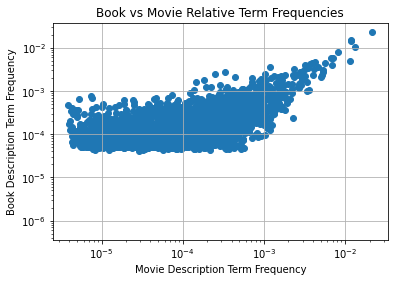

In [7]:
corpus_term_freq = np.asarray(np.sum(tfidf_coupus_desc, axis=0)).squeeze()
movie_desc_term_freq = np.asarray(np.sum(tfidf_movie_desc, axis=0)).squeeze()
book_desc_term_freq = np.asarray(np.sum(tfidf_book_desc, axis=0)).squeeze()

movie_desc_term_freq = movie_desc_term_freq / np.sum(movie_desc_term_freq)
book_desc_term_freq = book_desc_term_freq / np.sum(book_desc_term_freq)

plt.scatter(movie_desc_term_freq, book_desc_term_freq)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.title('Book vs Movie Relative Term Frequencies')
plt.xlabel('Movie Description Term Frequency')
plt.ylabel('Book Description Term Frequency')

### 2.2 Genre Frequencies

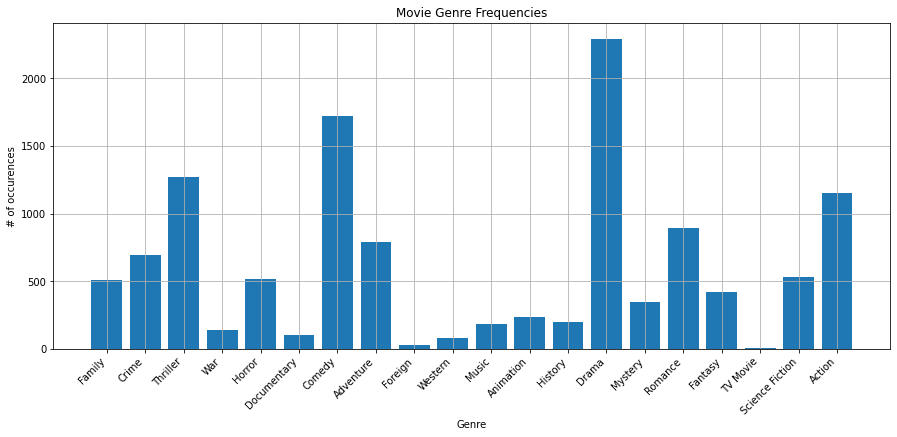

In [8]:
# Count the number of occurances of each movie genre
movie_genre_set = set(chain(*movies.genres))
movie_genre_counts = {genre_name: 0 for genre_name in movie_genre_set}
for i, genres in enumerate(movies.genres):
    for genre_name in movie_genre_set:
        movie_genre_counts[genre_name] += sum(g == genre_name for g in genres)

plt.figure(figsize=(15, 6))
plt.bar(
    x=list(movie_genre_counts.keys()),
    height=list(movie_genre_counts.values()),
)
plt.xticks(rotation=45, ha="right")
plt.title('Movie Genre Frequencies')
plt.ylabel('# of occurences')
plt.xlabel('Genre')
plt.grid(True)

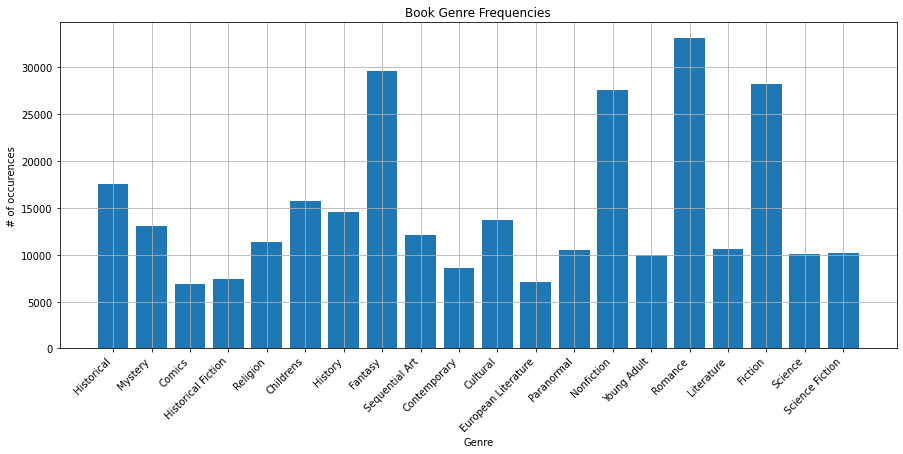

In [9]:
# Count the number of occurrences of each movie genre
book_genres = [str(g).split(',') for g in books.genre]
book_genres = [[x for x in g if x != 'nan'] for g in book_genres]
book_genre_set = set(chain(*book_genres))
book_genre_counts = {genre_name: 0 for genre_name in book_genre_set}
for i, genres in enumerate(book_genres):
    for genre_name in book_genre_set:
        book_genre_counts[genre_name] += sum(g == genre_name for g in genres)

# Pick the 20 most common genres to plot (there are 1180 genres overall)
value = sorted(book_genre_counts.values(), reverse=True)[20]
book_genre_counts = {
    key: book_genre_counts[key] for key in book_genre_counts
    if book_genre_counts[key] > value
}


plt.figure(figsize=(15, 6))
plt.bar(
    x=list(book_genre_counts.keys()),
    height=list(book_genre_counts.values()),
)
plt.xticks(rotation=45, ha="right")
plt.title('Book Genre Frequencies')
plt.ylabel('# of occurences')
plt.xlabel('Genre')
plt.grid(True)

## 3.0 Intra-Medium Similarity Metrics

In this section, we will explore different similarity metrics to compare movies to other movies and books to other books.

In [10]:
class SimilarityRecommender:
    def __init__(
        self, 
        metric=None,
        minimize=False,
        dataset=None,
        names=None
    ):
        self.metric = metric
        self.minimize = minimize
        self.dataset=dataset
        self.names = list(names)         
        if names is not None:
            self._name2idx = {n: i for i, n in enumerate(names)}
            self._idx2name = {i: n for i, n in enumerate(names)}
        else:
            self._name2idx = None
            self._idx2name = None
    
    def predict(self, x=None, index=None, name=None, top_n=1):
        """Predict the closest match to the entry with the given name"""
        if name:
            assert x is None
            assert index is None
            index = self._name2idx[name]
            x = self.dataset[index]
        if index:
            assert x is None
            assert name is None
            x = self.dataset[index]

        # Compute the score against each element in the dataset
        scores = self.metric(self.dataset, x)
        scores = np.array(scores)
        scores = np.squeeze(scores)
        scores = list(enumerate(scores))

        # Sort the scores from best to worst
        scores = sorted(scores, key=lambda x: x[1], reverse=not self.minimize)
        scores = scores[:top_n]

        # Convert output to a dataframe
        df = pd.DataFrame({
            'index': [s[0] for s in scores],
            'score': [s[1] for s in scores]    
        })
        if self._idx2name:
            df['name'] = [self._idx2name[s[0]] for s in scores]
        df = df.set_index('index')
        return df

### 3.1 Movie-Movie Cosine Similarity

In [11]:
movie_cosine_sim = SimilarityRecommender(
    metric=cosine_similarity,
    minimize=False,
    dataset=tfidf_movie_desc,
    names=movies.original_title
)

# Test out by comparing to the movie "Avatar"
matches_df = movie_cosine_sim.predict(name='Avatar', top_n=6)

print('Top 6 matches to movie "Avatar" using cosine-similarity of overviews:')
matches_df['genres'] = movies.genres[matches_df.index]
matches_df['overview'] = movies.overview[matches_df.index]
display(matches_df)

Top 6 matches to movie "Avatar" using cosine-similarity of overviews:


score                         name  \
index                                          
0      1.000000                       Avatar   
3601   0.299186                    Apollo 18   
1213   0.240031  Aliens vs Predator: Requiem   
2966   0.218975   E.T. the Extra-Terrestrial   
151    0.201517                      Beowulf   
3721   0.195304                Falcon Rising   

                                                  genres  \
index                                                      
0          [Action, Adventure, Fantasy, Science Fiction]   
3601                 [Horror, Thriller, Science Fiction]   
1213   [Fantasy, Action, Science Fiction, Thriller, H...   
2966       [Science Fiction, Adventure, Family, Fantasy]   
151                       [Adventure, Action, Animation]   
3721                                 [Adventure, Action]   

                                                overview  
index                                                     
0      In the 22nd century, a paraplegic Marine is di...  
3601   Officially, Apollo 17 was the last manned miss...  
1213   A sequel to 2004's Alien vs. Predator, the ico...  
2966   After a gentle alien becomes stranded on Earth...  
151    6th-century Scandinavian warrior, Beowulf emba...  
3721   Chapman is an ex-marine in Brazil's slums, bat...

### 3.2 Movie-Movie Euclidean Distance

In [12]:
movie_euclid_dist = SimilarityRecommender(
    metric=euclidean_distances,
    minimize=True,
    dataset=tfidf_movie_desc,
    names=movies.original_title
)
# Test out by comparing to the movie "Avatar"
matches_df = movie_euclid_dist.predict(name='Avatar', top_n=6)

print('Top 6 matches to movie "Avatar" using euclidean distance of overviews:')
matches_df['genres'] = movies.genres[matches_df.index]
matches_df['overview'] = movies.overview[matches_df.index]
display(matches_df)

Top 6 matches to movie "Avatar" using euclidean distance of overviews:


score                         name  \
index                                          
0      0.000000                       Avatar   
3601   1.183904                    Apollo 18   
1213   1.232858  Aliens vs Predator: Requiem   
2966   1.249820   E.T. the Extra-Terrestrial   
151    1.263711                      Beowulf   
3721   1.268618                Falcon Rising   

                                                  genres  \
index                                                      
0          [Action, Adventure, Fantasy, Science Fiction]   
3601                 [Horror, Thriller, Science Fiction]   
1213   [Fantasy, Action, Science Fiction, Thriller, H...   
2966       [Science Fiction, Adventure, Family, Fantasy]   
151                       [Adventure, Action, Animation]   
3721                                 [Adventure, Action]   

                                                overview  
index                                                     
0      In the 22nd century, a paraplegic Marine is di...  
3601   Officially, Apollo 17 was the last manned miss...  
1213   A sequel to 2004's Alien vs. Predator, the ico...  
2966   After a gentle alien becomes stranded on Earth...  
151    6th-century Scandinavian warrior, Beowulf emba...  
3721   Chapman is an ex-marine in Brazil's slums, bat...

### 3.3 Book-Book Cosine Similarity

In [13]:
book_cosine_sim = SimilarityRecommender(
    metric=cosine_similarity,
    minimize=False,
    dataset=tfidf_book_desc,
    names=books.title
)

# Test out by comparing to the book
bookname = books.title[0]
matches_df = book_cosine_sim.predict(name=bookname, top_n=6)

print('Top 6 matches to book "%s" using cosine-similarity of overviews:' % bookname)
matches_df['genres'] = books.genre[matches_df.index]
matches_df['overview'] = books.desc[matches_df.index]
display(matches_df)

Top 6 matches to book "Between Two Fires: American Indians in the Civil War" using cosine-similarity of overviews:


score                                               name  \
index                                                                
0      1.000000  Between Two Fires: American Indians in the Civ...   
65456  0.315378      A History of the Indians of the United States   
47618  0.311452      Hippies, Indians, and the Fight for Red Power   
53982  0.299103  Wild Frenchmen and Frenchified Indians: Materi...   
73515  0.298453  Deadly Medicine: Indians and Alcohol in Early ...   
19632  0.295601  The Native Ground: Indians and Colonists in th...   

                                                  genres  \
index                                                      
0      History,Military History,Civil War,American Hi...   
65456  History,Nonfiction,Native Americans,North Amer...   
47618                   History,Politics,Race,Nonfiction   
53982                    History,Literature,18th Century   
73515                                            History   
19632  History,Nonfiction,North American Hi...,Americ...   

                                                overview  
index                                                     
0      Reveals that several hundred thousand Indians ...  
65456  In 1906 when the Creek Indian Chitto Harjo was...  
47618  Through much of the 20th century, federal poli...  
53982  Based on a sweeping range of archival, visual,...  
73515  Alcohol abuse has killed and impoverished Amer...  
19632  In ,The Native Ground,, Kathleen DuVal argues ...

### 3.4 Book-Book Euclidean Distance

In [14]:
# Computing cosine similarity matrix using euclidean_distances of sklearn
book_euclid_dist = SimilarityRecommender(
    metric=euclidean_distances,
    minimize=True,
    dataset=tfidf_book_desc,
    names=books.title
)

# Test out by comparing to the book
bookname = books.title[0]
matches_df = book_euclid_dist.predict(name=bookname, top_n=6)

print('Top 6 matches to book "%s" using cosine-similarity of overviews:' % bookname)
matches_df['genres'] = books.genre[matches_df.index]
matches_df['overview'] = books.desc[matches_df.index]
display(matches_df)

Top 6 matches to book "Between Two Fires: American Indians in the Civil War" using cosine-similarity of overviews:


score                                               name  \
index                                                                
0      0.000000  Between Two Fires: American Indians in the Civ...   
65456  1.170147      A History of the Indians of the United States   
47618  1.173497      Hippies, Indians, and the Fight for Red Power   
53982  1.183974  Wild Frenchmen and Frenchified Indians: Materi...   
73515  1.184523  Deadly Medicine: Indians and Alcohol in Early ...   
19632  1.186928  The Native Ground: Indians and Colonists in th...   

                                                  genres  \
index                                                      
0      History,Military History,Civil War,American Hi...   
65456  History,Nonfiction,Native Americans,North Amer...   
47618                   History,Politics,Race,Nonfiction   
53982                    History,Literature,18th Century   
73515                                            History   
19632  History,Nonfiction,North American Hi...,Americ...   

                                                overview  
index                                                     
0      Reveals that several hundred thousand Indians ...  
65456  In 1906 when the Creek Indian Chitto Harjo was...  
47618  Through much of the 20th century, federal poli...  
53982  Based on a sweeping range of archival, visual,...  
73515  Alcohol abuse has killed and impoverished Amer...  
19632  In ,The Native Ground,, Kathleen DuVal argues ...

## 4.0 Inter-Medium Similarity Metrics

In this section, we will explore different similarity metrics to compare movies to books and books to movies.

### 4.1 Movie to Book Cosine Similarity

In [15]:
# Find the index of Avatar movie
index = movie_cosine_sim._name2idx['Avatar']

# Test compare books to "Avatar"
matches_df = book_cosine_sim.predict(tfidf_movie_desc[index], top_n=6)

print('Top 6 matches to movie "Avatar" using cosine-similarity of overviews:')
matches_df['genres'] = books.genre[matches_df.index]
matches_df['overview'] = books.desc[matches_df.index]
display(matches_df)

Top 6 matches to movie "Avatar" using cosine-similarity of overviews:


score                                               name  \
index                                                                
60925  0.291834  The Once and Future Moon (Library of the Solar...   
57786  0.265492                                    Eight Days Gone   
4541   0.261933                              New Atlas of the Moon   
61298  0.256740                              What the Moon Is Like   
80590  0.253538                                         Last Watch   
33205  0.242780                                      Caliban's War   

                                                  genres  \
index                                                      
60925                    Science,Astronomy,Science,Space   
57786  Childrens,Picture Books,Space,Nonfiction,Histo...   
4541                           Science,Astronomy,Science   
61298  Science,Childrens,Picture Books,Space,Science,...   
80590                  Science Fiction,Short Stories,40k   
33205  Science Fiction,Fiction,Space,Space Opera,Audi...   

                                                overview  
index                                                     
60925  Describes the scientific legacy of the 1960's ...  
57786  Snappy verse and retro art recount Apollo 11's...  
4541   Designed for day-to-day observing of the moon ...  
61298  Imagine that you're walking on the moon.,What ...  
80590  A lone Space Marine in service to the Deathwat...  
33205  We are not alone.,On Ganymede, breadbasket of ...

### 4.2 Movie to Book Euclidean Distance

In [16]:
# Find the index of Avatar movie
index = movie_euclid_dist._name2idx['Avatar']

# Test compare books to "Avatar"
matches_df = book_euclid_dist.predict(tfidf_movie_desc[index], top_n=6)

print('Top 6 matches to movie "Avatar" using cosine-similarity of overviews:')
matches_df['genres'] = books.genre[matches_df.index]
matches_df['overview'] = books.desc[matches_df.index]
display(matches_df)

Top 6 matches to movie "Avatar" using cosine-similarity of overviews:


score                                               name  \
index                                                                
60925  1.190097  The Once and Future Moon (Library of the Solar...   
57786  1.212030                                    Eight Days Gone   
4541   1.214963                              New Atlas of the Moon   
61298  1.219230                              What the Moon Is Like   
80590  1.221853                                         Last Watch   
33205  1.230625                                      Caliban's War   

                                                  genres  \
index                                                      
60925                    Science,Astronomy,Science,Space   
57786  Childrens,Picture Books,Space,Nonfiction,Histo...   
4541                           Science,Astronomy,Science   
61298  Science,Childrens,Picture Books,Space,Science,...   
80590                  Science Fiction,Short Stories,40k   
33205  Science Fiction,Fiction,Space,Space Opera,Audi...   

                                                overview  
index                                                     
60925  Describes the scientific legacy of the 1960's ...  
57786  Snappy verse and retro art recount Apollo 11's...  
4541   Designed for day-to-day observing of the moon ...  
61298  Imagine that you're walking on the moon.,What ...  
80590  A lone Space Marine in service to the Deathwat...  
33205  We are not alone.,On Ganymede, breadbasket of ...

### 4.3 Book to Movie Cosine Similarity

In [17]:
# Find the index of Avatar movie
index = 0
bookname = books.title[index]

# Test compare books to "Avatar"
matches_df = movie_cosine_sim.predict(tfidf_book_desc[index], top_n=6)

print('Top 6 matches to book "%s" using cosine-similarity of overviews:' % bookname)
matches_df['genres'] = movies.genres[matches_df.index]
matches_df['overview'] = movies.overview[matches_df.index]
display(matches_df)

Top 6 matches to book "Between Two Fires: American Indians in the Civil War" using cosine-similarity of overviews:


score              name                         genres  \
index                                                              
4206   0.341863     दिल जो भी कहे                      [Romance]   
236    0.225252       Windtalkers  [Drama, Action, History, War]   
4257   0.223567           Shalako                      [Western]   
4268   0.175532         Vượt Sóng                        [Drama]   
2397   0.174654      Hotel Rwanda          [Drama, History, War]   
1818   0.167571  Schindler's List          [Drama, History, War]   

                                                overview  
index                                                     
4206   During the British rule in India, several Indi...  
236    Joe Enders is a gung-ho Marine assigned to pro...  
4257   Sean Connery is Shalako, a guide in the old We...  
4268   Thirteen years after the end of the Vietnam Wa...  
2397   Inspired by true events, this film takes place...  
1818   The true story of how businessman Oskar Schind...

### 4.4 Book to Movie Euclidean Distance

In [18]:
# Find the index of Avatar movie
index = 0
bookname = books.title[index]

# Test compare books to "Avatar"
matches_df = movie_euclid_dist.predict(tfidf_book_desc[index], top_n=6)

print('Top 6 matches to book "%s" using cosine-similarity of overviews:' % bookname)
matches_df['genres'] = movies.genres[matches_df.index]
matches_df['overview'] = movies.overview[matches_df.index]
display(matches_df)

Top 6 matches to book "Between Two Fires: American Indians in the Civil War" using cosine-similarity of overviews:


score              name                         genres  \
index                                                              
4206   1.147289     दिल जो भी कहे                      [Romance]   
236    1.244787       Windtalkers  [Drama, Action, History, War]   
4257   1.246140           Shalako                      [Western]   
4268   1.284109         Vượt Sóng                        [Drama]   
2397   1.284793      Hotel Rwanda          [Drama, History, War]   
1818   1.290294  Schindler's List          [Drama, History, War]   

                                                overview  
index                                                     
4206   During the British rule in India, several Indi...  
236    Joe Enders is a gung-ho Marine assigned to pro...  
4257   Sean Connery is Shalako, a guide in the old We...  
4268   Thirteen years after the end of the Vietnam Wa...  
2397   Inspired by true events, this film takes place...  
1818   The true story of how businessman Oskar Schind...

## 5.0 Recommendations using BERT

In this section we will explore making recommendations using embeddings of the book and movie descriptions, using Bidirectional Encoder Representations from Transformers (BERT). The potential advantage of BERT is that it takes into account the meaning and context of words, rather than just matching exact works as the simple similarity metrics do. 

In [19]:
# Transform the movie and book descriptions to embeddings
bert = SentenceTransformer('bert-base-nli-mean-tokens')

print('Encoding Movie Descriptions ... ')
movie_desc_embeddings = bert.encode(
    movies.overview,
    show_progress_bar=True,
    normalize_embeddings=True,
    device='cuda'
)

print('Encoding Book Descriptions ... ')
book_desc_embeddings = bert.encode(
    books.desc,
    show_progress_bar=True,
    normalize_embeddings=True,
    device='cuda'
)

Encoding Movie Descriptions ... 


Batches:   0%|          | 0/150 [00:00<?, ?it/s]

Encoding Book Descriptions ... 


Batches:   0%|          | 0/2778 [00:00<?, ?it/s]

In [20]:
print('Movie Embeddings: ', movie_desc_embeddings.shape)
print('Book Embeddings:  ', book_desc_embeddings.shape)

Movie Embeddings:  (4794, 768)
Book Embeddings:   (88890, 768)


### 5.1 Movie-Movie Recommendation Using BERT

In [21]:
# Create a recommender using the embedding data and the dot_score metric
movie_rec_bert = SimilarityRecommender(
    metric=dot_score,
    minimize=False,
    dataset=movie_desc_embeddings,
    names=movies.original_title
)

# Test out by comparing to the movie "Avatar"
matches_df = movie_rec_bert.predict(name='Avatar', top_n=6)

print('Top 6 matches to movie "Avatar" using BERT embeddings:')
matches_df['genres'] = movies.genres[matches_df.index]
matches_df['overview'] = movies.overview[matches_df.index]
display(matches_df)

Top 6 matches to movie "Avatar" using BERT embeddings:


score                           name  \
index                                            
0      1.000000                         Avatar   
2129   0.875755                 The Black Hole   
3157   0.864378                          Alien   
1198   0.863662       Escape from Planet Earth   
461    0.861471                  Lost in Space   
1959   0.857778  Star Trek IV: The Voyage Home   

                                                  genres  \
index                                                      
0          [Action, Adventure, Fantasy, Science Fiction]   
2129        [Adventure, Family, Science Fiction, Action]   
3157         [Horror, Action, Thriller, Science Fiction]   
1198   [Animation, Comedy, Adventure, Family, Science...   
461                 [Adventure, Family, Science Fiction]   
1959                        [Science Fiction, Adventure]   

                                                overview  
index                                                     
0      In the 22nd century, a paraplegic Marine is di...  
2129   The explorer craft U.S.S. Palomino is returnin...  
3157   During its return to the earth, commercial spa...  
1198   Astronaut Scorch Supernova finds himself caugh...  
461    The prospects for continuing life on Earth in ...  
1959   Fugitives of the Federation for their daring r...

### 5.2 Book-Book Recommendaton Using BERT

In [22]:
# Create a recommender using the embedding data and the dot_score metric
book_rec_bert = SimilarityRecommender(
    metric=dot_score,
    minimize=False,
    dataset=book_desc_embeddings,
    names=books.title
)

# Find the nearest matches to the given book
bookname = books.title[0]
matches_df = book_rec_bert.predict(name=bookname, top_n=6)

print('Top 6 matches to book "%s" using BERT embeddings:' % bookname)
matches_df['genres'] = books.genre[matches_df.index]
matches_df['overview'] = books.desc[matches_df.index]
display(matches_df)

Top 6 matches to book "Between Two Fires: American Indians in the Civil War" using BERT embeddings:


score                                               name  \
index                                                                
0      1.000000  Between Two Fires: American Indians in the Civ...   
71802  0.813262  A Misplaced Massacre: Struggling Over the Memo...   
34610  0.801507  West Virginia and the Civil War: Mountaineers ...   
54075  0.796110                     Kalaupapa: A Collective Memory   
68995  0.792223  In the Kingdom of the Sick: A Social History o...   
12224  0.785781  The Beauty and the Sorrow: An Intimate History...   

                                                  genres  \
index                                                      
0      History,Military History,Civil War,American Hi...   
71802  History,Nonfiction,North American Hi...,Americ...   
34610                         Military History,Civil War   
54075             History,Reference,Autobiography,Memoir   
68995  Nonfiction,Health,History,Health,Medicine,Scie...   
12224  History,Nonfiction,War,World War I,War,War,Mil...   

                                                overview  
index                                                     
0      Reveals that several hundred thousand Indians ...  
71802  In the early morning of November 29, 1864, wit...  
34610  The only state born as a result of the Civil W...  
54075  Between 1866 and 1969, an estimated 8,000 indi...  
68995  Thirty years ago, Susan Sontag wrote, "Everyon...  
12224  Four devastating years told by twenty eyewitne...

### 5.3 Movie to Book Recommendation Using BERT

In [23]:
# Find the index of Avatar movie
index = movie_rec_bert._name2idx['Avatar']

# Test compare books to "Avatar"
matches_df = book_rec_bert.predict(movie_desc_embeddings[index], top_n=6)

print('Top 6 matches to movie "Avatar" using BERT embeddings:')
matches_df['genres'] = books.genre[matches_df.index]
matches_df['overview'] = books.desc[matches_df.index]
display(matches_df)

Top 6 matches to movie "Avatar" using BERT embeddings:


score                        name  \
index                                         
32058  0.873850     Doctor Who: Galaxy Four   
87349  0.870643                    Tin Star   
81901  0.869396       Explorers on the Moon   
33012  0.864460                Battle Earth   
2057   0.864437        Doctor Who: Red Dawn   
62009  0.862115  Doctor Who: Mawdryn Undead   

                                                  genres  \
index                                                      
32058  Media Tie In,Doctor Who,Science Fiction,Fictio...   
87349  Science Fiction,Young Adult,Science Fiction,Al...   
81901  Sequential Art,Comics,Sequential Art,Graphic N...   
33012  Science Fiction,Fiction,Business,Amazon,Scienc...   
2057   Media Tie In,Doctor Who,Science Fiction,Audiob...   
62009  Media Tie In,Doctor Who,Science Fiction,Fictio...   

                                                overview  
index                                                     
32058  Noveliztion of the ,Doctor Who, TV episodes/st...  
87349  On their way to start a new life, Tula and her...  
81901  The first manned rocked, bound for the Moon, h...  
33012  A distress transmission from Mars research col...  
2057   Ares One: NASA's first manned mission to the d...  
62009  The Doctor's time-travelling machine is trappe...

### 5.4 Movie to Book Recommendation Using BERT

In [24]:
# Find the index of Avatar movie
index = 0
bookname = book_rec_bert._idx2name[index]

# Test compare books to "Avatar"
matches_df = movie_rec_bert.predict(book_desc_embeddings[index], top_n=6)

print('Top 6 matches to book "%s" using BERT embeddings:' % bookname)
matches_df['genres'] = books.genre[matches_df.index]
matches_df['overview'] = books.desc[matches_df.index]
display(matches_df)

Top 6 matches to book "Between Two Fires: American Indians in the Civil War" using BERT embeddings:


score                       name  \
index                                        
3112   0.707552  Cinco de Mayo: La Batalla   
787    0.684665             The Great Raid   
2897   0.683444                     南京!南京!   
426    0.668088           The Hunger Games   
3719   0.667388                    Airlift   
2034   0.665165               Delivery Man   

                                                  genres  \
index                                                      
3112                          Humor,Media Tie In,Fiction   
787    Politics,Presidents,History,Biography,Biograph...   
2897   Historical,Historical Fiction,Fiction,Cultural...   
426    Womens Fiction,Chick Lit,Romance,Contemporary,...   
3719   Mystery,Fiction,Horror,Thriller,Mystery,Crime,...   
2034   Science Fiction,Science Fiction,Alternate Hist...   

                                                overview  
index                                                     
3112   While on an early morning bushwalk, Bindi and ...  
787    National Review has called a "magisterial work...  
2897   A magnificent romantic/historical/adventure no...  
426    A hilarious and romantic standalone novel from...  
3719   Cass Neary made her name in the 1970s as a pho...  
2034   From Harry Turtledove, bestselling author and ...